In [24]:
import json
import copy
import tqdm
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
from collections import defaultdict

from VecnaWarehouseEnv import VecnaWarehouseEnv

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 18, 6

## Utils for Model Learning

In [2]:
def rolling_average(data, window_size):
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(np.ones_like(data), kernel)
    return smooth_data[: -window_size + 1]

In [3]:
# e-Greedy action selection for a policy
def select_action_epsilon_greedy(Q_array, eps):
    if rnd.rand() < eps:
        num_actions = Q_array.shape[0]
        action = rnd.randint(num_actions)
    else:
        actions_maximal = np.argwhere(Q_array == Q_array.max()).flatten()
        action = rnd.choice(actions_maximal)
    return action

In [5]:
# Scheduler for decaying the agent exploration (epsilon value)
class LinearSchedule:
    def __init__(self, value_from, value_to, nsteps):
        self.value_from = value_from
        self.value_to = value_to
        self.nsteps = nsteps

    def value(self, step):
        if step <= 0:
            value = self.value_from
        elif step >= self.nsteps - 1:
            value = self.value_to
        else:
            value = self.value_from + ((self.value_to - self.value_from) / (self.nsteps - 1)) * step
        return value

## Policy Learning using Q-Learning

In [9]:
# Toy warehouse environment
vwh = VecnaWarehouseEnv()

In [10]:
# Tabular Q learning algorithm
def tabular_q_learning(env, num_episodes, num_steps_max, alpha, gamma, exploration):
    Q = defaultdict(
        lambda: np.zeros(env.action_space.n))
    returns = np.empty(num_episodes)
    lengths = np.empty(num_episodes, dtype=np.int)
    exploration_steps = 0
    for i in tqdm.tnrange(num_episodes, desc='Episodes', leave=False):
        prev_state = env.reset()
        episode_length = 0
        episode_return = 0
        for j in range(num_steps_max):
            epsilon = exploration.value(i)
            action = select_action_epsilon_greedy(Q[prev_state], eps=epsilon)
            curr_state, reward, done, _ = env.step(action)
            td = reward + (gamma * np.max(Q[curr_state])) - Q[prev_state][action]
            Q[prev_state][action] = Q[prev_state][action] + alpha * (td)
            exploration_steps += 1
            episode_length += 1
            episode_return += reward
            if done:
                break
            prev_state = curr_state
        returns[i] = episode_return
        lengths[i] = episode_length
    return Q, returns, lengths

## Agent Training

In [11]:
# Train model for 100,000 episodes to learn a reasonable policy
num_runs, num_episodes, num_steps_max = 10, 100_000, 100
returns_ql_fl = np.empty((num_runs, num_episodes))
lengths_ql_fl = np.empty((num_runs, num_episodes), dtype=np.int)

exp = LinearSchedule(100, 0.02, num_episodes/10)
for i in tqdm.tnrange(num_runs, desc='Runs'):
    Q, ret, lens = tabular_q_learning(vwh, num_episodes, num_steps_max, alpha=0.1, gamma=1, exploration=exp)
    returns_ql_fl[i] = ret
    lengths_ql_fl[i] = lens

C:\Users\afrid\AppData\Local\Temp\ipykernel_21220\1092333270.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  lengths_ql_fl = np.empty((num_runs, num_episodes), dtype=np.int)
C:\Users\afrid\AppData\Local\Temp\ipykernel_21220\1092333270.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tqdm.tnrange(num_runs, desc='Runs'):


Runs:   0%|          | 0/10 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

Episodes:   0%|          | 0/100000 [00:00<?, ?it/s]

## Analysis of the trained model

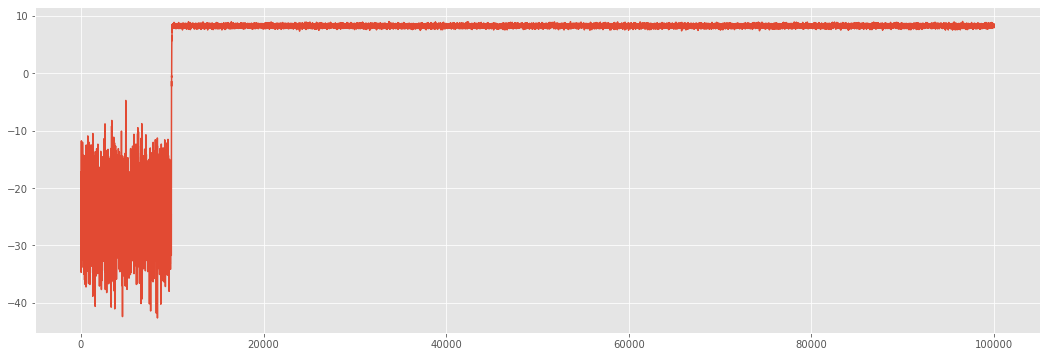

In [21]:
ret_avg = np.mean(returns_ql_fl, 0)
len_avg = np.mean(lengths_ql_fl, 0)

# plot average rewards per
plt.plot(list(range(ret_avg.size)), rolling_average(ret_avg, window_size=5))

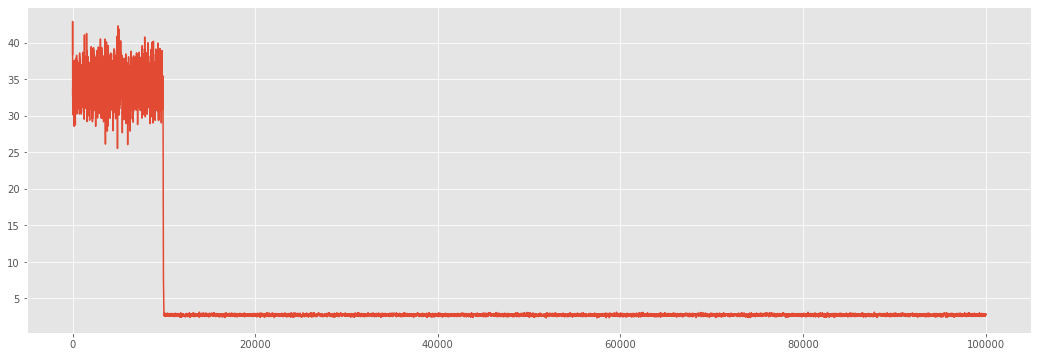

In [22]:
# Plot average number of steps to reach the goal, while avoiding the dynamic obstacle
plt.plot(list(range(len_avg.size)), rolling_average(len_avg, window_size=20))

In [25]:
# Save the tabular policy
tabular_policy = dict(Q)

json_tabular_policy = {}
for k in tabular_policy:
    json_tabular_policy[str(k)] = list(tabular_policy[k])


# print(json.dumps(json_tabular_policy))
with open("policy.json", "w") as p:
    p.write(json.dumps(json_tabular_policy))